In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from markdown import MarkDownSeries
from data_preprocessing import preprocess_data
from cleaning import cleaning_data

### Reading in our data

In [2]:
RawData = pd.read_csv('vgchartz-2024.csv')

In [3]:
preprocessed_RawData = preprocess_data(RawData)
cleaned_data = cleaning_data(preprocessed_RawData)

All items are covered.


From our cleaning function 

In [4]:
categories = {
    'nintendo': ['3ds', 'dsiw', 'dsi', 'ds', 'wii', 'wiiu', 'ns', 'gb', 'gba', 'nes', 'snes', 'gbc', 'n64', 'vb', 'gc', 'vc','ww'], # noqa
    'pc': ['linux', 'osx', 'pc', 'arc', 'all', 'fmt', 'c128', 'aco'],
    'xbox': ['x360', 'xone', 'series', 'xbl', 'xb', 'xs'],
    'sony': ['ps', 'ps2', 'ps3', 'ps4', 'ps5', 'psp', 'psv', 'psn', 'cdi'],
    'mobile': ['ios', 'and', 'winp', 'ngage', 'mob'],
    'sega': ['gg', 'msd', 'ms', 'gen', 'scd', 'sat', 's32x', 'dc'],
    'atari': ['2600', '7800', '5200', 'aj', 'int'],
    'commodore': ['amig', 'c64', 'cd32'],
    'other': ['ouya', 'or', 'acpc', 'ast', 'apii', 'pce', 'zxs', 'lynx', 'ng', 'zxs', '3do', 'pcfx', 'ws', 'brw', 'cv', 'giz', 'msx', 'tg16', 'bbcm'] # noqa
}

Converting the categories dictionary to a markdown table for later use. 

In [5]:
categoriesList = []
for manufacturer, consoles in categories.items():
    for console in consoles:
        categoriesList.append({'manufacturer': manufacturer, 'console': console})

mfg_list = pd.DataFrame(categoriesList)
grouped_series = mfg_list.groupby('manufacturer')['console'].apply(list)
markdown_table = MarkDownSeries(grouped_series)

# print(markdown_table)

| manufacturer | console |
|---|---|
| atari | 2600, 7800, 5200, aj, int |
| commodore | amig, c64, cd32 |
| mobile | ios, and, winp, ngage, mob |
| nintendo | 3ds, dsiw, dsi, ds, wii, wiiu, ns, gb, gba, nes, snes, gbc, n64, vb, gc, vc, ww |
| other | ouya, or, acpc, ast, apii, pce, zxs, lynx, ng, zxs, 3do, pcfx, ws, brw, cv, giz, msx, tg16, bbcm |
| pc | linux, osx, pc, arc, all, fmt, c128, aco |
| sega | gg, msd, ms, gen, scd, sat, s32x, dc |
| sony | ps, ps2, ps3, ps4, ps5, psp, psv, psn, cdi |
| xbox | x360, xone, series, xbl, xb, xs |


This script processes sales data by grouping and summing the sales for each console by year,

creating dynamic variables for easy access. It defines a function, `filter_and_group_by_year`,

which filters and groups the data for a specified year, summing the sales for each console.

The script then iterates over the years from 1971 to 2023, constructing variable names in the

format `sales_YYYY` (e.g., `sales_1971`, `sales_1972`, etc.). Using the `globals()` function,

it dynamically creates these variables and assigns them the processed sales data for each year.

After execution, variables like `sales_1971`, `sales_1972`, etc., store the grouped and summed

sales data, enabling straightforward access and analysis for each year.

In [6]:
def filter_and_group_by_year(df, target_year):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df_filtered = df[df['release_date'].dt.year == target_year]
    result = df_filtered.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()
    result['release_date'] = result['release_date'].dt.year  
    result = result.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()
    return result

for year in range(1971, 2024):
    df_name = f"sales_{year}"
    globals()[df_name] = filter_and_group_by_year(cleaned_data, year)

In [7]:
sales_2001

,release_date,console,total_sales
0,2001,2600,0.00
1,2001,all,0.00
2,2001,dc,1.43
3,2001,gb,4.48
4,2001,gba,34.51
5,2001,gbc,3.78
6,2001,gc,8.29
7,2001,mob,0.00
8,2001,n64,3.50
9,2001,ng,0.00


In [8]:
def single_graph(date_range, console):
    cleaned_data['release_date'] = pd.to_datetime(cleaned_data['release_date']) 
    filtered_df = cleaned_data[(cleaned_data['release_date'].dt.year >= date_range[0]) &
                     (cleaned_data['release_date'].dt.year <= date_range[1]) &
                     (cleaned_data['console'] == console)]
    sales_by_year = filtered_df.groupby(filtered_df['release_date'].dt.year)['total_sales'].sum().reset_index() 
    plt.figure(figsize=(10, 6))
    plt.bar(sales_by_year['release_date'], sales_by_year['total_sales'], label='Total Sales')
    # Trend curve
    x = sales_by_year['release_date']
    y = sales_by_year['total_sales']
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)

    # Clip values below 0
    trend_line = np.maximum(p(x), 0)  
    plt.plot(x, trend_line, 'r--', label='Trend Curve')
    plt.xlabel('Year')
    plt.ylabel('Total Sales')
    plt.title(f'Total Sales of {console} from {date_range[0]} to {date_range[1]}')
    plt.legend()
    plt.show()

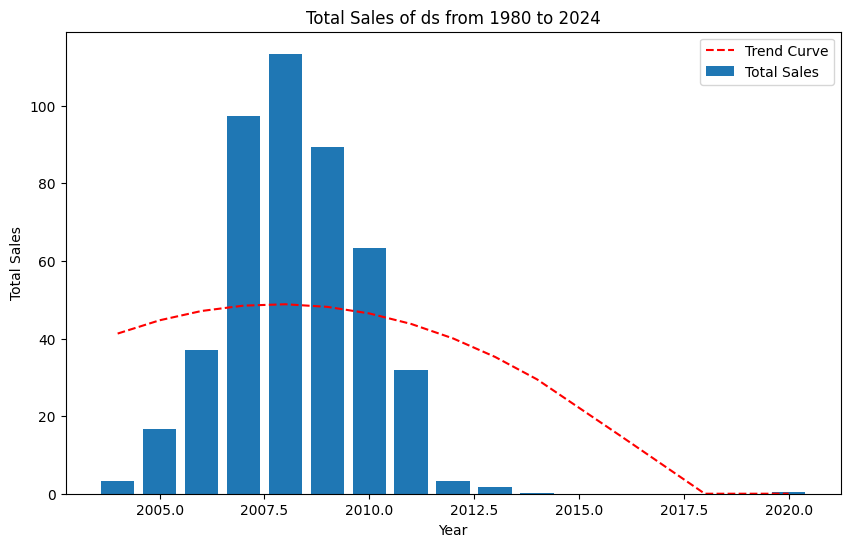

In [9]:
single_graph((1980, 2024), 'ds')

In [10]:
def stacked_graph(date_range, *consoles):  
    cleaned_data['release_date'] = pd.to_datetime(cleaned_data['release_date'])
    filtered_df = cleaned_data[(cleaned_data['release_date'].dt.year >= date_range[0]) & 
                     (cleaned_data['release_date'].dt.year <= date_range[1]) & 
                     (cleaned_data['console'].isin(consoles))]
    sales_by_year = filtered_df.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()
    plt.figure(figsize=(12, 8))
    for console in consoles:
        console_data = sales_by_year[sales_by_year['console'] == console]
        x = console_data['release_date'].dt.year  
        y = console_data['total_sales']
        # Trend curve
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)
        # Clip values below 0
        trend_line = np.maximum(p(x), 0) 
        # Bar plot
        plt.bar(x, y, label=f'Total Sales - {console}')
        # Trend curve plot
        plt.plot(x, trend_line, '--', label=f'Trend Curve - {console}')
    plt.xlabel('Year')
    plt.ylabel('Total Sales')
    plt.title(f'Total Sales Comparison of Consoles from {date_range[0]} to {date_range[1]}')
    # Display legend
    plt.legend()
    plt.show()

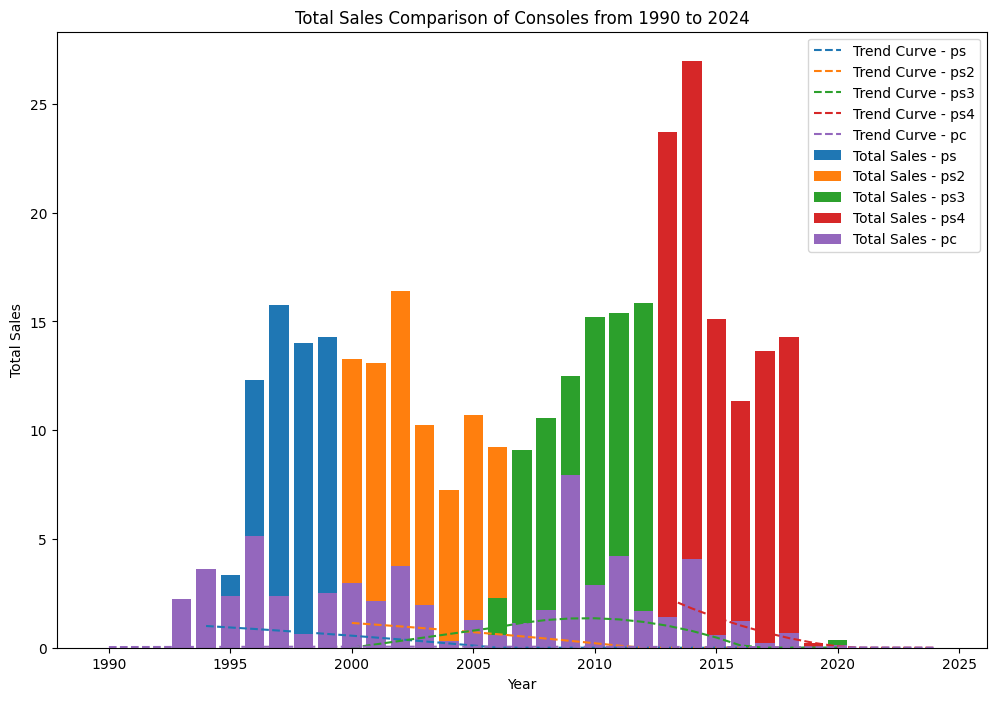

In [11]:
stacked_graph((1990, 2024), 'ps', 'ps2', 'ps3', 'ps4', 'pc')

In [12]:
def graph(date_range, *consoles):
    cleaned_data['release_date'] = pd.to_datetime(cleaned_data['release_date'])
    filtered_df = cleaned_data[(cleaned_data['release_date'].dt.year >= date_range[0]) & 
                     (cleaned_data['release_date'].dt.year <= date_range[1]) & 
                     (cleaned_data['console'].isin(consoles))]
    sales_by_year = filtered_df.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()
    plt.figure(figsize=(12, 8))
    for i, console in enumerate(consoles):
        console_data = sales_by_year[sales_by_year['console'] == console]
        x = console_data['release_date'].dt.year  
        y = console_data['total_sales']
        # Trend curve
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)
        # Clip values below 0
        trend_line = np.maximum(p(x), 0)  
        cmap = plt.get_cmap('tab10')
        bar_color = cmap(i)
        darker_bar_color = tuple(c * 0.6 for c in bar_color)
        plt.bar(x + i * 0.3, y, width=0.3, color=bar_color, label=f'Total Sales - {console}')
        plt.plot(x, trend_line, '-', color=darker_bar_color, linewidth=2, label=f'Trend Curve - {console}', zorder=10)
    plt.xlabel('Year')
    plt.ylabel('Total Sales')
    plt.title(f'Total Sales Comparison of Consoles from {date_range[0]} to {date_range[1]}')
    plt.legend()
    plt.show()

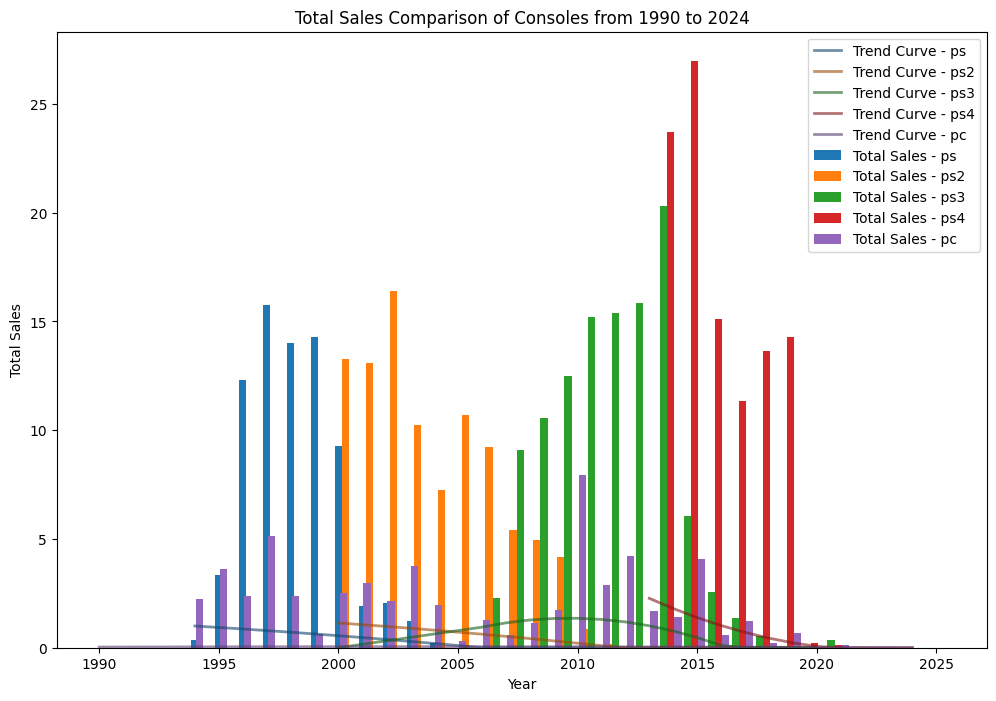

In [13]:
graph((1990, 2024), 'ps', 'ps2', 'ps3', 'ps4', 'pc')

In [14]:
def graph_genre(date_range, *genres):
    cleaned_data['release_date'] = pd.to_datetime(cleaned_data['release_date'])  
    filtered_df = cleaned_data[(cleaned_data['release_date'].dt.year >= date_range[0]) & 
                     (cleaned_data['release_date'].dt.year <= date_range[1]) & 
                     (cleaned_data['genre'].isin(genres))]
    sales_by_year = filtered_df.groupby(['release_date', 'genre'])['total_sales'].sum().reset_index()
    plt.figure(figsize=(12, 8)) 
    for i, genre in enumerate(genres):
        genre_data = sales_by_year[sales_by_year['genre'] == genre]
        x = genre_data['release_date'].dt.year  
        y = genre_data['total_sales'] 
        # Trend curve
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)
        # Clip values below 0
        trend_line = np.maximum(p(x), 0)  
        cmap = plt.get_cmap('tab10')
        bar_color = cmap(i)
        darker_bar_color = tuple(c * 0.6 for c in bar_color)
        plt.bar(x + i * 0.3, y, width=0.3, color=bar_color, label=f'Total Sales - {genre}')
        plt.plot(x, trend_line, '-', color=darker_bar_color, linewidth=2, label=f'Trend Curve - {genre}', zorder=10)
    plt.xlabel('Year')
    plt.ylabel('Total Sales')
    plt.title(f'Total Sales Comparison of Genres from {date_range[0]} to {date_range[1]}')
    plt.legend()
    plt.show()

In [15]:
genre_md = cleaned_data['genre'].value_counts()
# print(MarkDownSeries(genre_md))

| genre | count |
|---|---|
| Misc | 8932 |
| Action | 7440 |
| Adventure | 5370 |
| Sports | 5341 |
| Role-Playing | 4929 |
| Shooter | 4760 |
| Platform | 3556 |
| Strategy | 3305 |
| Puzzle | 3139 |
| Racing | 3095 |
| Simulation | 2829 |
| Fighting | 2143 |
| Action-Adventure | 1190 |
| Visual Novel | 424 |
| Music | 259 |
| Party | 103 |
| MMO | 92 |
| Board Game | 22 |
| Education | 21 |
| Sandbox | 15 |

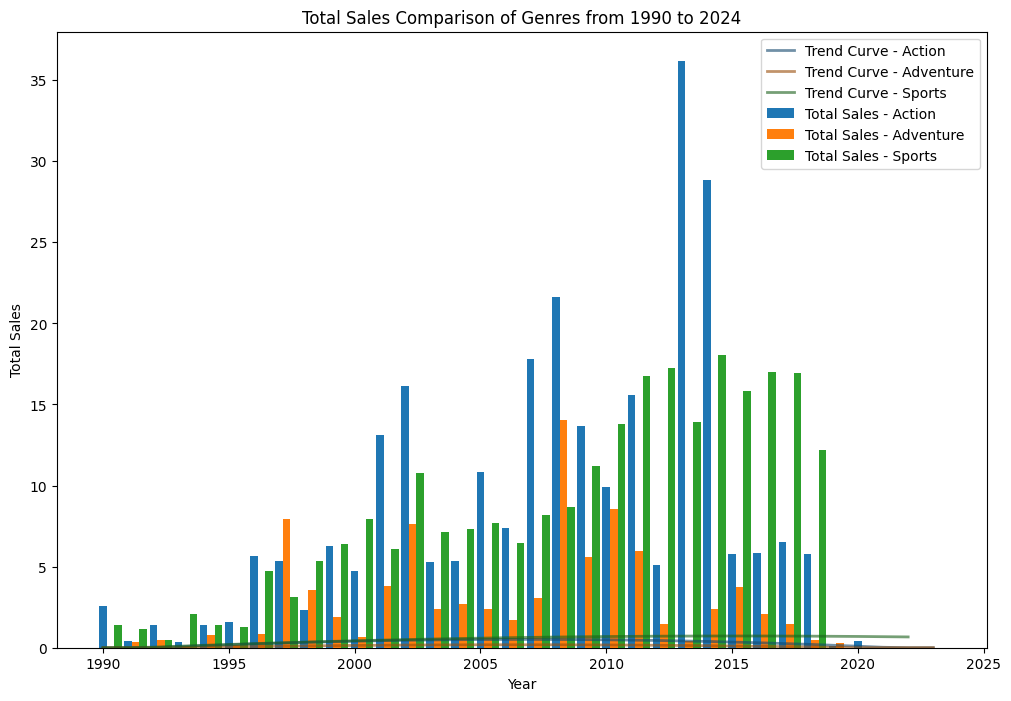

In [16]:
graph_genre((1990, 2024), 'Action', 'Adventure', 'Sports')

In [17]:
def graph_genre_quarterly(date_range, *genres): 
    cleaned_data['release_date'] = pd.to_datetime(cleaned_data['release_date'])
    filtered_df = cleaned_data[(cleaned_data['release_date'].dt.year >= date_range[0]) & 
                     (cleaned_data['release_date'].dt.year <= date_range[1]) & 
                     (cleaned_data['genre'].isin(genres))].copy()
    filtered_df['quarter'] = filtered_df['release_date'].dt.to_period("Q")
    sales_by_quarter = filtered_df.groupby(['quarter', 'genre'])['total_sales'].sum().reset_index()
    plt.figure(figsize=(15, 8))
    quarters = sales_by_quarter['quarter'].unique().astype(str)
    width = 0.2  # Adjusted width to make bars side-by-side
    for i, genre in enumerate(genres):
        genre_data = sales_by_quarter[sales_by_quarter['genre'] == genre]
        x = np.arange(len(quarters)) + i * width  # Adjusted x positions for side-by-side bars
        y = genre_data.groupby('quarter')['total_sales'].sum().reindex(quarters).fillna(0)
        cmap = plt.get_cmap('tab10')
        bar_color = cmap(i)
        plt.bar(x, y, width=width, color=bar_color, label=genre)
    plt.xlabel('Quarter')
    plt.ylabel('Total Sales')
    plt.title(f'Total Sales Comparison of Genres from {date_range[0]} to {date_range[1]} (Quarterly)')
    plt.legend(loc='upper left')
    plt.xticks(ticks=np.arange(len(quarters)) + width * (len(genres) - 1) / 2, labels=quarters, rotation=90)
    plt.show()

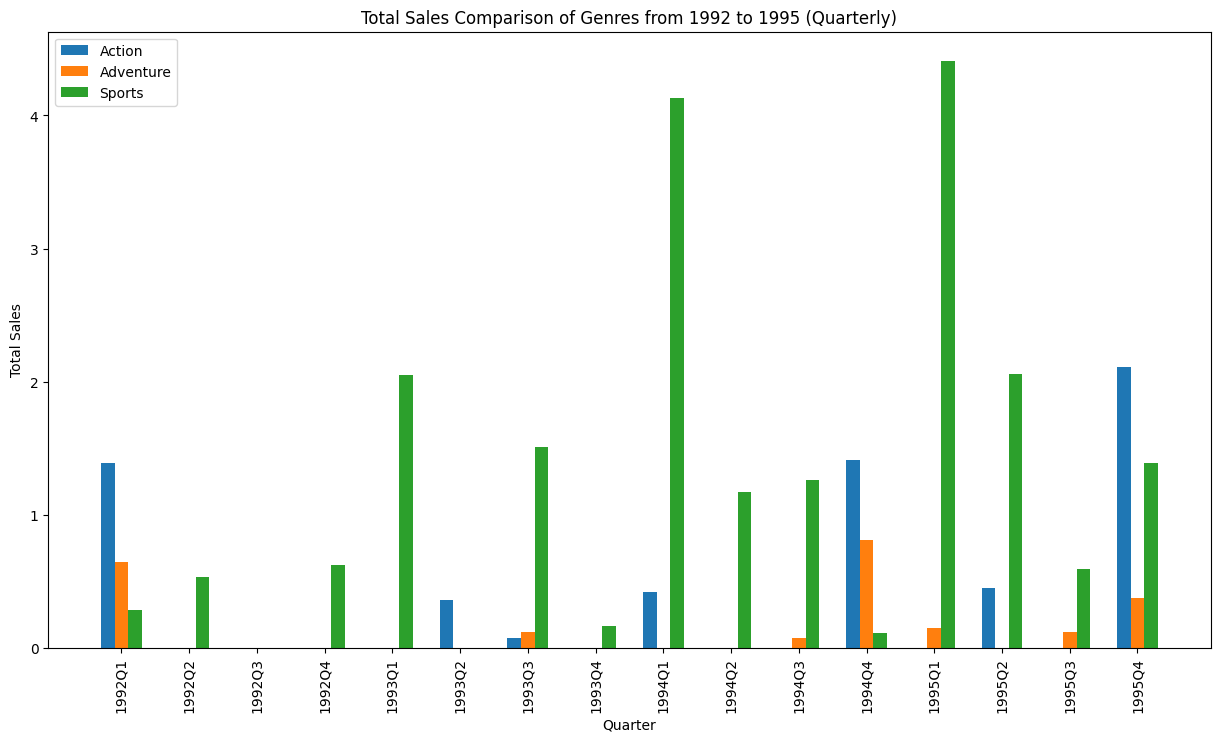

In [18]:
graph_genre_quarterly((1992, 1995), 'Action', 'Adventure', 'Sports')

In [20]:
def top_genre(genre):
    genre_df = cleaned_data[cleaned_data['genre'] == genre]
    if genre_df.empty:
        print(f"No data found for the genre: {genre}")
        return None
    top_titles = genre_df.nlargest(20, 'total_sales')[['title', 'total_sales']]
    return top_titles


def genre(cleaned_data, target_year):
    cleaned_data['release_date'] = pd.to_datetime(cleaned_data['release_date'])
    df_filtered = cleaned_data[cleaned_data['release_date'].dt.year == target_year]
    result = df_filtered.groupby(['release_date', 'genre'])['total_sales'].sum().reset_index()
    result['release_date'] = result['release_date'].dt.year  
    result = result.groupby(['release_date', 'genre'])['total_sales'].sum().reset_index()
    return result


for year in range(1971, 2024):
    df_name = f"genre_{year}"
    globals()[df_name] = genre(cleaned_data, year)




In [21]:
import connect 

conn = connect(':memory:')

cleaned_data.to_sql("df", conn)


def sql(a_string):
    return pd.read_sql(a_string, conn)

TypeError: 'module' object is not callable